## Load the model weights for the fine-tuned resnet

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python
from openslide import open_slide, __library_version__ as openslide_version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (153 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
import random
import glob
import cv2
import math
import re
import pathlib 
import time

from scipy.ndimage import rotate
from skimage.color import rgb2gray
from matplotlib import cm

In [3]:
# Note: x,y coords are with respect to level 0.
# Function to read a region from slide and return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Function to read a region from mask and return a single channel numpy array
def read_mask(slide, x, y, level, width, height, as_float=False):
  im = read_slide(slide, x, y, level, width, height, as_float=False)
  im = im[:,:,0]
  return im

# Function to identify tissue pixels (by filtering out grey areas)
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [4]:
levels = [4,5]
patch_shape = (224,224)
BATCH_SIZE = 256
BUFFER_SIZE = 1000

### Define and load the fine-tuned model

In [5]:
def import_resnet_tuned():
  model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  for layer in model.layers[:143]:
    layer.trainable = False
  return model

In [6]:
def define_stacked_model_tuned(members):
  for i in range(len(members)):
    model = members[i+1]
    for layer in model.layers:
      #layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

  # define multi input
  stacked_inputs = [model.input for model in members.values()]

  # concatenate output from each model
  stacked_outputs = [model.output for model in members.values()]
  merge = tf.keras.layers.Concatenate()(stacked_outputs)

  # defining the hidden and output layer 
  hidden = tf.keras.layers.GlobalAveragePooling2D()(merge)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
  model = tf.keras.Model(inputs=stacked_inputs, outputs=output)

  return model

In [7]:
members = {}
for i in range(len(levels)):
  members[i+1] = import_resnet_tuned()

ensemble_model_tuned = define_stacked_model_tuned(members)

94674944/94668760 [==============================] - 1s 0us/step


In [8]:
ensemble_model_tuned.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

In [9]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
# !!!if files are saved locally then this step is not necessary

Mounted at /content/gdrive


In [10]:
checkpoint_dir_ensemble_tuned = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir_ensemble_tuned = os.path.join(checkpoint_dir_ensemble_tuned, "final_project_ensemble_model_tuned")
# !!!this has to be changed to the actual path where the model weights are saved

In [11]:
latest = tf.train.latest_checkpoint(checkpoint_dir_ensemble_tuned)
if latest != None:
  print("Loading weights from", latest)
  ensemble_model_tuned.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_ensemble_model_tuned/cp-00000009.ckpt


### Define and load the non-finetuned model

In [30]:
def define_stacked_model(members):
  for i in range(len(members)):
    model = members[i+1]
    for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

  # define multi input
  stacked_inputs = [model.input for model in members.values()]

  # concatenate output from each model
  stacked_outputs = [model.output for model in members.values()]
  merge = tf.keras.layers.Concatenate()(stacked_outputs)

  # defining the hidden and output layer 
  hidden = tf.keras.layers.GlobalAveragePooling2D()(merge)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
  model = tf.keras.Model(inputs=stacked_inputs, outputs=output)

  return model

In [31]:
ensemble_model = define_stacked_model(members)

In [32]:
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

In [33]:
checkpoint_dir = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir = os.path.join(checkpoint_dir, "final_project_ensemble_model")

In [34]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  ensemble_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project/cp-00000004.ckpt


## Plotting the Heatmap

### Pre-processing the slide we want to plot the heatmap on

In [12]:
test_indexes = ['064', '001', '012']
#['064', '001', '012']
#We test our predictions with slide 064 first

In [13]:
raw_path = '/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Raw' 
# !!!this has to be changed to the actual path where the slide is
slide = '064'
levels = [4,5]
patch_shape = (224,224)

In [14]:
slide_path = raw_path + f'/tumor_{slide}.tif'
tumor_mask_path = raw_path + f'/tumor_{slide}_mask.tif'

test_slide = open_slide(slide_path)
test_mask = open_slide(tumor_mask_path)

In [15]:
test_image = read_slide(test_slide,
                                x=0,
                                y=0,
                                level=levels[0],
                                width=test_slide.level_dimensions[levels[0]][0],
                                height=test_slide.level_dimensions[levels[0]][1])

tumor_image = read_mask(test_mask,
                                x=0,
                                y=0,
                                level=levels[0],
                                width=test_mask.level_dimensions[levels[0]][0],
                                height=test_mask.level_dimensions[levels[0]][1])


In [16]:
#we have to use this resized plot to plot our heatmaps because having too large an image with too much range in its 
def resized_plot(slide_image, basewidth=1000): 
  from PIL import Image
  
  arr = np.copy(slide_image)
  img = Image.fromarray(arr)
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  a = np.asarray(img)
  return a

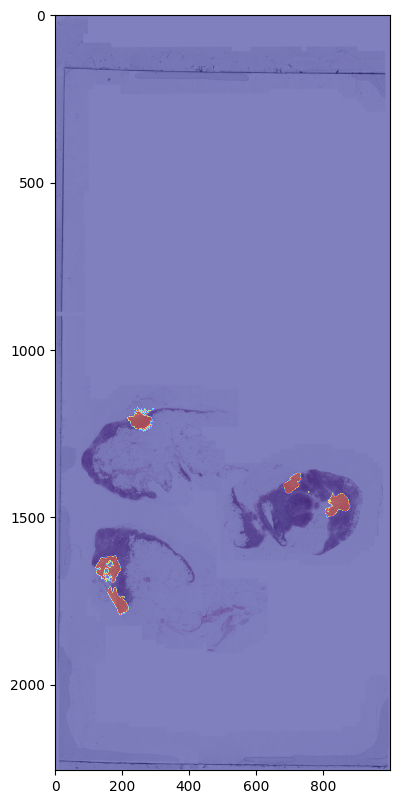

In [17]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(tumor_image), cmap='jet', alpha=0.5) # Red regions contains cancer.

In [18]:
patches_dict = {}
for level in levels:
  patches_dict['level' + str(level)] = []
patches_dict['labels'] = []

In [19]:
for vert_slide in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
  y_coord = int(vert_slide * test_slide.level_downsamples[levels[0]] * patch_shape[1])

  for horiz_slide in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
    x_coord = int(horiz_slide * test_slide.level_downsamples[levels[0]] * patch_shape[0])
    
    level_name = 'level' + str(levels[0])

    slide_image = read_slide(test_slide,
                                x=x_coord,
                                y=y_coord,
                                level=levels[0],
                                width=patch_shape[0],
                                height=patch_shape[1])

    patches_dict[level_name].append(slide_image)

    
    mask_image = read_mask(test_mask,
                                  x=x_coord,
                                  y=y_coord,
                                  level=levels[0],
                                  width=patch_shape[0],
                                  height=patch_shape[1])
    
    tissue_pixels = find_tissue_pixels(slide_image)
    mask_tissue_image = np.array([mask_image[pixels] for pixels in tissue_pixels])
    
    if mask_tissue_image.any() == False:
      patches_dict['labels'].append(0)
    else:
      patches_dict['labels'].append(1)
    
    for i in range(len(levels)-1):
          level_name = 'level' + str(levels[i+1])
          slide_image_zoomout = read_slide(test_slide,
                                            x=x_coord,
                                            y=y_coord,
                                            level=levels[i+1],
                                            width=patch_shape[0],
                                            height=patch_shape[1])
          
          patches_dict[level_name].append(slide_image_zoomout)

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((np.array(patches_dict['level4'])/255,np.array(patches_dict['level5'])/255))

In [21]:
dataset = dataset.batch(BATCH_SIZE)

### Running the Predictions on processed data:

In [22]:
predictions = []
for x1,x2 in dataset:
    predictions.extend(ensemble_model_tuned.predict_on_batch(x=[x1,x2]).tolist())

In [23]:
vert_patches = math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])
hor_patches = math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[1])

In [24]:
predictions = np.array(predictions)
predictions.resize(vert_patches,hor_patches)

In [25]:
test_heatmap = np.copy(tumor_image)
test_heatmap = test_heatmap.astype('float')

for j in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
  for i in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
    y = i*patch_shape[0]
    x = j*patch_shape[1]
    width = patch_shape[0]
    height = patch_shape[1]
    test_heatmap[y:y+height,x:x+width] = predictions[i,j]

In [26]:
assert test_heatmap.shape == test_image[:,:,0].shape

In [27]:
test_heatmap_filtered = np.copy(test_heatmap)
zero_filter = test_heatmap < 0.6
test_heatmap_filtered[zero_filter] = 0

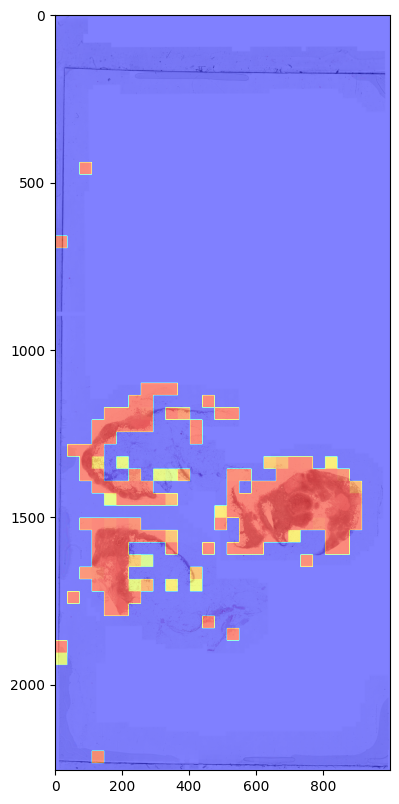

In [28]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(test_heatmap_filtered), cmap='jet', alpha=0.5) # Red regions contains cancer.

### Non finetuned model heatmap

In [36]:
predictions_untuned = []
for x1,x2 in dataset:
    predictions_untuned.extend(ensemble_model.predict_on_batch(x=[x1,x2]).tolist())

In [37]:
predictions_untuned = np.array(predictions_untuned)
predictions_untuned.resize(vert_patches,hor_patches)

In [42]:
test_heatmap = np.copy(tumor_image)
test_heatmap = test_heatmap.astype('float')

for j in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
  for i in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
    y = i*patch_shape[0]
    x = j*patch_shape[1]
    width = patch_shape[0]
    height = patch_shape[1]
    test_heatmap[y:y+height,x:x+width] = predictions_untuned[i,j]

In [43]:
assert test_heatmap.shape == test_image[:,:,0].shape

In [44]:
test_heatmap_filtered = np.copy(test_heatmap)
zero_filter = test_heatmap < 0.6
test_heatmap_filtered[zero_filter] = 0

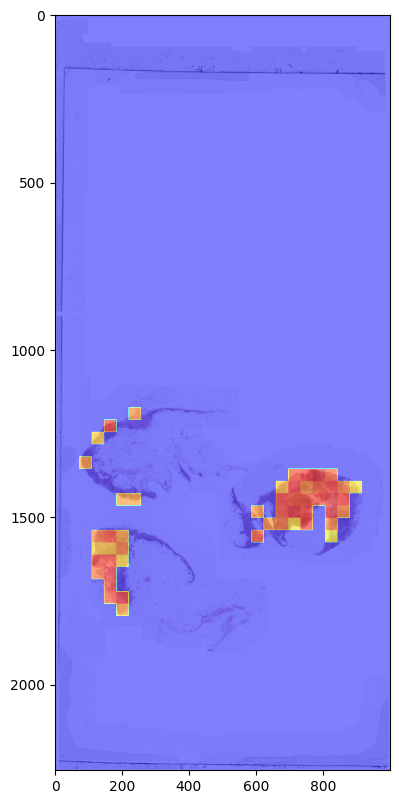

In [45]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(test_heatmap_filtered), cmap='jet', alpha=0.5) # Red regions contains cancer.